**Глава 2. Локальные дескрипторы изображений**

Навигация к соседним тетрадям:
<!--NAVIGATION-->
<[Глава 1. Основы обработки изображений](1_basic_image_handling_and_processing.ipynb) | [Содержание](0_index.ipynb) | [Глава 3. Преобразования изображений](3_image_to_image_mapping.ipynb)>

<a href="https://colab.research.google.com/github/mualal/computer-vision-with-python/blob/master/notebooks/2_local_image_descriptors.ipynb">    <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Открыть и запустить в Google Colaboratory"></a>

In [1]:
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
try:
    import google.colab, sys
    !git clone https://github.com/mualal/computer-vision-with-python.git
    sys.path.append('computer-vision-with-python')
    %cd computer-vision-with-python
except:
    import sys
    sys.path.append('..')

In [3]:
import sys
current_dir = os.path.abspath('')
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from improlib import harris, sift

# Детектор углов Харриса

Алгоритм обнаружения углов Харриса - один из простейших детекторов углов. Идея заключается в том, чтобы найти особые точки, в окрестности которых имеются границы в нескольких направлениях, это и есть угловые точки.

Определим положительно-полуопределённую симметричную матрицу $M_I=M_I(\textbf{x})$, где $\textbf{x}$ - точка внутри изображения:

$$M_I=\nabla I \,\nabla I^T=\begin{pmatrix}I_x \\ I_y\end{pmatrix} \begin{pmatrix}I_x & I_y \end{pmatrix}=\begin{pmatrix}I_x^2 & I_x I_y \\ I_x I_y & I_y^2\end{pmatrix}$$

По построению $M_I$ имеет ранг 1, а её собственные значения равны $\lambda_1=\left|\nabla I\right|^2$ и $\lambda_2=0$.

Таким образом, имеется по одной матрице для каждой точки изображения.

Введём матрицу весов $W$ (обычно = фильтр Гаусса $G_\sigma$). Операция поэлементной свёртки

$$\overline{M}_I=W*M_I$$

даёт локальное усреднение $M_I$ по соседним пикселям. Получающаяся матрица $\overline{M}_I$ - матрица Харриса. Ширина $W$ определяет размер окрестности $\textbf{x}$, представляющей интерес.

Смысл усреднения матрицы $M_I$ по области состоит в том, что собственные значения будут изменятся в зависимости от локальных свойств изображения. Если градиенты в этой области меняются, то второе собственное значение $\overline{M}_I$ не будет равно 0. Если же градиенты одинаковы, то собственные значения будут такими же, как у $M_I$.

В зависимости от значений градиента в области возможны 3 случая ($\lambda_1$ и $\lambda_2$ - собственные значения матрицы Харриса $\overline{M}_I$):
- $\lambda_1$ и $\lambda_2$ - большие положительные числа $\Rightarrow$ в точке $\textbf{x}$ имеется угол
- $\lambda_1$ велико, а $\lambda_2\approx 0$ $\Rightarrow$ существует граница; при усреднении $M_I$ по области её собственные значения изменяются не сильно
- $\lambda_1\approx\lambda_2\approx 0$ $\Rightarrow$ в точке нет никаких особенностей

Чтобы отличить существенный случай от остальных, Харрис и Стивенс ввели индикаторную функцию:

$$\det{\overline{M}_I}-\kappa\,\mathrm{tr}{\overline{M}_I}$$

Чтобы избавится от весовой постоянной $\kappa$, в качестве индикатора удобно использовать частное:

$$\frac{\det{\overline{M}_I}}{\mathrm{tr}{\overline{M}_I}}$$

In [4]:
im = Image.open(os.path.join(parent_dir, 'images_input', 'Peterhof.jpg')).resize((504, 378))
im_asarray_color = np.array(im)
im_asarray_gray = np.array(im.convert('L'))

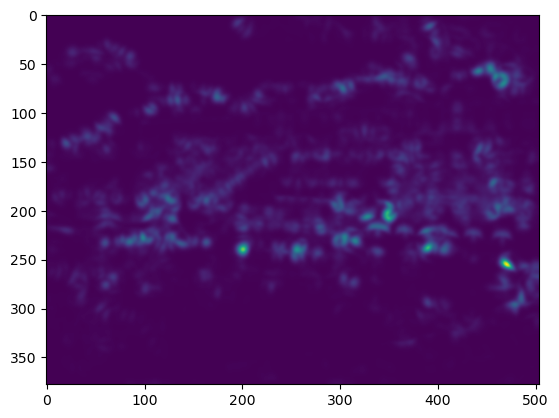

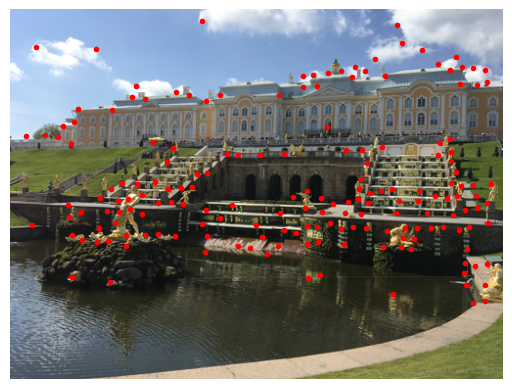

In [5]:
# значения функции отклика детектора углов Харриса для
# каждого пикселя полутонового изображения
harris_im = harris.compute_harris_response(im_asarray_gray)
# координаты углов Харриса
filtered_coords = harris.get_harris_points(harris_im, threshold=0.1)

# показ изображения-отклика Харриса
plt.figure()
plt.imshow(harris_im)
plt.show()

# показ изображения с найденными углами Харриса
harris.plot_harris_points(im_asarray_color, filtered_coords)

## Нахождение соответственных точек на изображениях

Для нахождения соответственных точек на изображениях необходимо снабдить каждую особую точку Харриса дескриптором и предложить способ сравнения дескрипторов.

**Дескриптор особой точки** - это сопоставленный точке вектор, который описывает окрестность этой точки на изображении. Чем лучше дескриптор, тем качественнее будет соответствие.

Угловые точки Харриса обычно комбинируются с дескриптором, состоящим из значений яркости в окружающем блоке изображения и нормированной взаимной корреляции.

В общем случае корреляция между двумя блоками изображения одинакового размера $I_1$ и $I_2$ определяется как

$$c(I_1, I_2)=\sum_{\textbf{x}}f\!\left(I_1(\textbf{x}), I_2(\textbf{x})\right),$$

где $f$ зависит от метода вычисления корреляции. Суммирование производится по всем точкам $\textbf{x}$ в блоке изображения.

В случае **взаимной корреляции** в качестве $f$ берётся функция $f(I_1, I_2)=I_1I_2$.

**Нормированная взаимная корреляция** - это вариант взаимной корреляции, который определяется следующим образом:

$$\mathrm{ncc}\left(I_1, I_2\right)=\frac{1}{n-1}\sum_{x}\frac{I_1(\textbf{x})-\mu_1}{\sigma_1}\frac{I_2(\textbf{x})-\mu_2}{\sigma_2},$$

где $n$ - число пикселей в блоке, $\mu_1$ и $\mu_2$ - средние яркости, а $\sigma_1$ и $\sigma_2$ - стандартные отклонения в каждом блоке.

Благодаря вычитанию средних и нормировке на стандартное отклонение этот метод слабо чувствителен к изменению яркости изображения.

Ищу соответствия


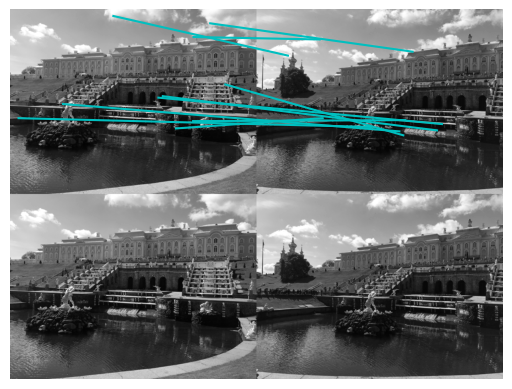

In [6]:
# нахождение соответствий; результат применения нормированной взаимной корреляции к блокам,
# окружающим угловые точки Харриса
im1 = np.array(Image.open(os.path.join(parent_dir, 'images_input', 'Peterhof.jpg')).resize((504, 378)).convert('L'))
im2 = np.array(Image.open(os.path.join(parent_dir, 'images_input', 'Peterhof2.jpg')).resize((504, 378)).convert('L'))
# 2*wid+1 - ширина рассматриваемых окрестностей для точек Харриса
wid = 5

harris_im1 = harris.compute_harris_response(im1, sigma=5)
filtered_coords1 = harris.get_harris_points(harris_im1, min_dist=wid+1)
d1 = harris.get_descriptors(im1, filtered_coords1, wid)

harris_im2 = harris.compute_harris_response(im2, sigma=5)
filtered_coords2 = harris.get_harris_points(harris_im2, min_dist=wid+1)
d2 = harris.get_descriptors(im2, filtered_coords2, wid)

print('Ищу соответствия')
matches = harris.match_descriptors_twosided(d1, d2)
harris.plot_matches(im1, im2, filtered_coords1, filtered_coords2, matches[50:100])


Получили много неправильных соответствий. Объясняется это тем, что взаимная корреляция блоков изображений даёт не такие точные результаты, как более современные методы. Ещё одна проблема связана с тем, что эти дескрипторы не инвариантны относительно масштабирования или поворота.

# SIFT - масштабно-инвариантное преобразование признаков

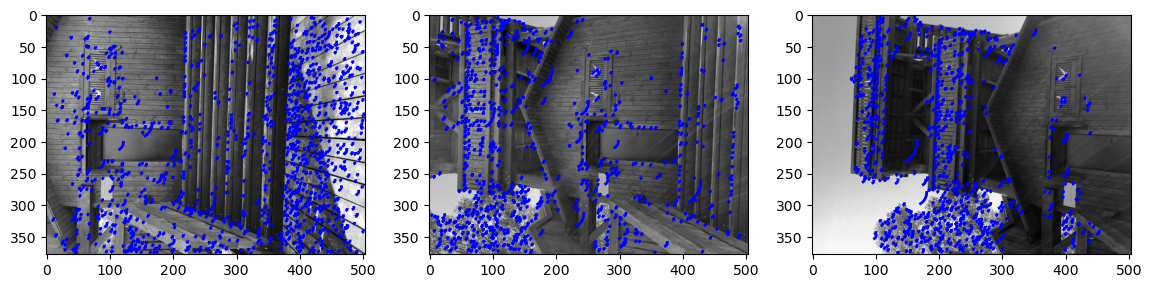

In [7]:
paths = [
    os.path.join(parent_dir, 'images_input', 'Kotlin1.jpg'),
    os.path.join(parent_dir, 'images_input', 'Kotlin2.jpg'),
    os.path.join(parent_dir, 'images_input', 'Kotlin3.jpg')
]
size = (504, 378)

plt.figure(figsize=(14, 5))
for i, path in enumerate(paths):
    plt.subplot(1, 3, i + 1)
    sift.plot_sift_points(path, size)

## Сопоставление дескрипторов

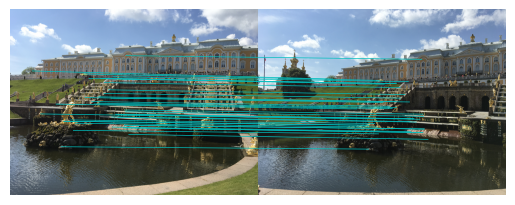

In [8]:
from scipy import ndimage
img1 = np.array(Image.open(os.path.join(parent_dir, 'images_input', 'Peterhof.jpg')))
img2 = np.array(Image.open(os.path.join(parent_dir, 'images_input', 'Peterhof2.jpg')))

sift_points_1, descriptors_1 = sift.find_sift_points_and_descriptors(ndimage.gaussian_filter(img1, 20))
sift_points_2, descriptors_2 = sift.find_sift_points_and_descriptors(ndimage.gaussian_filter(img2, 20))

matches = sift.match_twosided(descriptors_1, descriptors_2)

sift.plot_matches(
    img1,
    img2,
    [(p.pt[1], p.pt[0]) for p in sift_points_1],
    [(p.pt[1], p.pt[0]) for p in sift_points_2],
    matches[0:100],
    show_below=False,
    save_to_file=os.path.join(parent_dir, 'images_output', 'Peterhof_matches.jpg')
)

<!--NAVIGATION-->
<[Глава 1. Основы обработки изображений](1_basic_image_handling_and_processing.ipynb) | [Содержание](0_index.ipynb) | [Глава 3. Преобразования изображений](3_image_to_image_mapping.ipynb)>

<a href="https://colab.research.google.com/github/mualal/computer-vision-with-python/blob/master/notebooks/2_local_image_descriptors.ipynb">    <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Открыть и запустить в Google Colaboratory"></a>